In [1]:
import sys, os, pickle
sys.path.append('/scratch/oem214/vanilla-rtrl/')
from cluster import *
from continual_learning import *
from core import *
from dynamics import *
from functions import *
from gen_data import *
from learning_algorithms import *
from optimizers import *
from plotting import *
from wrappers import *

In [ ]:
### --- SET UP ALL CONFIGS --- ###
from itertools import product
n_seeds = 5
macro_configs = config_generator(lr=[0.0003, 0.001, 0.003],
                                 phi=['tanh', 'relu'],
                                 mu=[0.3, 0.6, 0.9],
                                 n_h=[32, 64])
micro_configs = tuple(product(macro_configs, list(range(n_seeds))))

### --- SELECT PARTICULAR CONFIG --- ###
try:
    i_job = int(os.environ['SLURM_ARRAY_TASK_ID']) - 1
except KeyError:
    i_job = 0
params, i_seed = micro_configs[i_job]
i_config = i_job//n_seeds

new_random_seed_per_condition = True
if new_random_seed_per_condition:
    np.random.seed(i_job)
else: #Match random seeds across conditions
    np.random.seed(i_seed)

In [ ]:
task = Flip_Flop_Task(3, 0.05, input_magnitudes=None)
N_train = 200000
N_test = 5000
checkpoint_interval = None
sigma = 0

data = task.gen_data(N_train, N_test)

n_in = task.n_in
n_hidden = params['n_h']
n_out = task.n_out
W_in  = np.random.normal(0, np.sqrt(1/(n_in)), (n_hidden, n_in))
W_rec = np.random.normal(0, np.sqrt(1/n_hidden), (n_hidden, n_hidden))
W_out = np.random.normal(0, np.sqrt(1/(n_hidden)), (n_out, n_hidden))

b_rec = np.zeros(n_hidden)
b_out = np.zeros(n_out)

alpha = 1
sigma = 0

if params['phi'] == 'tanh':
    phi = tanh
elif params['phi'] == 'relu':
    phi = relu
    
rnn = RNN(W_in, W_rec, W_out, b_rec, b_out,
          activation=phi,
          alpha=alpha,
          output=identity,
          loss=mean_squared_error)

#learn_alg = Efficient_BPTT(rnn, T_truncation=6, L2_reg=0.0001, L1_reg=0.0001)
#sg_optimizer = Stochastic_Gradient_Descent(lr=0.001)
#learn_alg = DNI(rnn, sg_optimizer)
#learn_alg = KF_RTRL(rnn, L2_reg=0.0001, L1_reg=0.0001)
learn_alg = RFLO(rnn, alpha=alpha, L2_reg=0.0001, L1_reg=0.0001)
optimizer = SGD_Momentum(lr=params['lr'], mu=params['mu'])

monitors = []

sim = Simulation(rnn)
sim.run(data, learn_alg=learn_alg, optimizer=optimizer,
        sigma=sigma,
        monitors=monitors,
        verbose=True,
        report_accuracy=False,
        report_loss=True,
        checkpoint_interval=checkpoint_interval)

In [ ]:
### --- Analyze final checkpoint --- ###

checkpoint = sim.checkpoints[max(sim.checkpoints.keys())]

default_analysis_args = {'sigma_pert': 0.5, 'N': 1200, 'KE_criterion': 0.001,
                         'N_iters': 10000, 'same_LR_criterion': 9000,
                         'sigma': 0}
default_graph_args = {'N': 100, 'time_steps': 50, 'epsilon': 0.01,
                      'sigma': 0}
default_input_graph_args = {'N': 100, 'time_steps': 50, 'epsilon': 0.01,
                            'sigma': 0}

analyze_checkpoint(checkpoint, data, verbose=False, parallelize=False,
                   **default_analysis_args)

get_graph_structure(checkpoint, parallelize=False, background_input=0,
                    **default_graph_args)
get_input_dependent_graph_structure(checkpoint,
                                    parallelize=False,
                                    inputs=task.probe_inputs,
                                    **default_input_graph_args)
processed_data = np.mean(checkpoint['nodes'].shape[0])

In [ ]:
### --- SAVE RESULTS -- ###
result = {'sim': sim, 'i_seed': i_seed, 'task': task,
          'config': params, 'i_config': i_config, 'i_job': i_job}
try:
    result['processed_data'] = processed_data
except NameError:
    pass
    
try:
    save_dir = os.environ['SAVEDIR']
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    save_path = os.path.join(save_dir, 'result_{}'.format(i_job))

    with open(save_path, 'wb') as f:
        pickle.dump(result, f)
except KeyError:
    pass

In [ ]:
###Truncate file above
file_name = 'array_end_topology'
job_name = 'RELU_end_array'
get_ipython().run_cell_magic('javascript', '', 'IPython.notebook.save_notebook()')
get_ipython().system('jupyter nbconvert --to script --no-prompt {}.ipynb'.format(file_name))
get_ipython().system('awk "/###Truncate/ {{exit}} {{print}}" {}.py'.format(file_name))
get_ipython().system('sed -i "/###Truncate/Q" {}.py'.format(file_name))
get_ipython().system('mv {}.py ../cluster_main_scripts/{}.py'.format(file_name, job_name))

In [ ]:
###Submit job to cluster
n_jobs = len(micro_configs)
write_job_file(job_name, py_file_name='{}.py'.format(job_name))
job_id_1 = submit_job('../job_scripts/{}.s'.format(job_name), n_jobs)

In [2]:
job_name = 'RELU_end_array'

In [ ]:
###Get job status
get_ipython().system('squeue -u oem214')

In [3]:
configs_array, results_array, key_order, sim_dict = unpack_processed_data('../job_scripts/{}.s'.format(job_name))

In [ ]:
fig = plot_2d_array_of_config_results(configs_array, results_array, key_order,
                                      log_scale=False, tick_rounding=5, vmin=0, vmax=1)

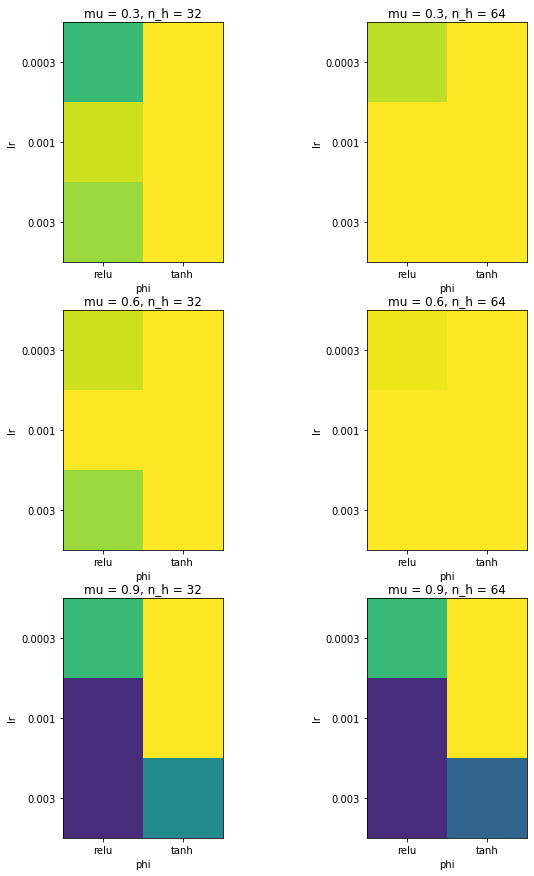

In [8]:
fig = plot_3d_or_4d_array_of_config_results(configs_array, results_array, key_order, tick_rounding=5,
                                            vmin=0, vmax=8)

In [9]:
figs_path = 'figs/compare_algorithms/'
fig.savefig(os.path.join(figs_path, '{}.pdf'.format('RELU_n_nodes_array')), format='pdf')

In [ ]:
key_order

In [ ]:
sim = sim_dict['0.001_0.9_32_3']
plot_output_from_checkpoint(sim.checkpoints[max(sim.checkpoints.keys())], data)

In [ ]:
task = Flip_Flop_Task(3, 0.05, input_magnitudes=None)
N_train = 200000
N_test = 5000
checkpoint_interval = None
sigma = 0

data = task.gen_data(N_train, N_test)

In [ ]:
configs_array